# Classification of Gods using CNN
Here we train 5 classes-
1. Brahma
2. Ganesha
3. Hanuman
4. Shiva
5. Vishnu

## 1. Preparing the dataset

In [1]:
import cv2
import glob
import os
import PIL
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from functools import partial
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Check if there are faulty images in the dataset

In [2]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'G:\Projects\Gods Classification\Model to train\dataset\Test'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Brahma
processing class directory  Ganesha
processing class directory  Hanuman
processing class directory  Shiva
processing class directory  Vishnu
 no improper image files were found


### Specify the trainpath

In [3]:
train_path = 'G:/Projects/Gods Classification/Model to train/dataset/Train/*'
cls_paths = glob.glob(train_path)
img_classes = [x.split('\\')[1] for x in cls_paths]
img_shape = (400,400)

### Functions to preprocess image

In [4]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    vertical_flip=False)

def crop_image(img):
    crop_factor = min(img.shape[0:2]) / max(img.shape[0:2])
    if img.shape[0] > img.shape[1]:
        crop = img[int(img.shape[0] * (1 - crop_factor) / 2):int(img.shape[0] * (1 + crop_factor) / 2), :,:]
    else:
        crop = img[:, int(img.shape[1] * (1 - crop_factor) / 2):int(img.shape[1] * (1 + crop_factor) / 2),:]
    return crop

def preprocess_img(img, mode='train',train_mode= 'normal'):
    img = np.float32(img)
    img = crop_image(img)
    img = cv2.resize(img, img_shape,interpolation=cv2.INTER_AREA)
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
            
    if train_mode == 'canny':
        img = cv2.Canny(np.uint8(img),80,200)
    
    if train_mode == 'grey':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    if img.shape == img_shape:
        img = img[:,:,np.newaxis]
    
    img = (img - img.min())/(img.max() - img.min())
    return img

### Create Datasets for Training and Validation using AugmentedDataGenerator

In [5]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', train_mode='normal', ablation=None, classes = img_classes, 
                 batch_size=32, dim=img_shape, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(classes):
            paths = glob.glob(os.path.join(train_path.strip("/*"), cls, '*'))
            if self.mode=='test':
                paths = glob.glob(os.path.join(test_path.strip("/*"), cls, '*'))
            brk_point = int(len(paths)*0.2)
            if self.mode == 'train':
                paths = paths[brk_point:]
            elif self.mode=='test':
                pass
            else:
                paths = paths[:brk_point]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.train_mode = train_mode
        self.n_channels = 1
        if train_mode == 'normal':
            self.n_channels = 3
        self.n_classes = len(classes)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID)
            if i==1:
                plt.imshow(img)
            if img is not None:
                if (img.shape[2] == 3):
                    img = preprocess_img(img, self.mode,self.train_mode)
                    X[i,] = img
                    y[i] = self.labels[ID]

                else:
                    delete_rows.append(i)
                    continue
            if i==1:
                plt.imshow(img)
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, np.reshape(tf.keras.utils.to_categorical(y, num_classes=5),(-1,5))

# 2. Train and run first model

In [6]:
num_classes = len(img_classes)
num_channels = 3
train_mode = 'normal'
if train_mode!='normal':
    num_channels=1

model = Sequential([
    layers.Conv2D(16, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])


In [7]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer= 'adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        1

In [10]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode,ablation=10)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode,ablation=10)
history = model.fit(training_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
5/5 [==============================] - 10s 2s/step - loss: 1.5221 - accuracy: 0.2875 - val_loss: 1.5109 - val_accuracy: 0.3293
Epoch 2/5
5/5 [==============================] - 11s 3s/step - loss: 1.4949 - accuracy: 0.3438 - val_loss: 1.5380 - val_accuracy: 0.3005
Epoch 3/5
5/5 [==============================] - 11s 2s/step - loss: 1.4555 - accuracy: 0.3750 - val_loss: 1.5149 - val_accuracy: 0.3029
Epoch 4/5
5/5 [==============================] - 10s 2s/step - loss: 1.4374 - accuracy: 0.3938 - val_loss: 1.5139 - val_accuracy: 0.3173
Epoch 5/5
5/5 [==============================] - 10s 2s/step - loss: 1.3855 - accuracy: 0.4437 - val_loss: 1.4881 - val_accuracy: 0.3486


### Define a function to plot losses of train and validation

In [6]:
def plot_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

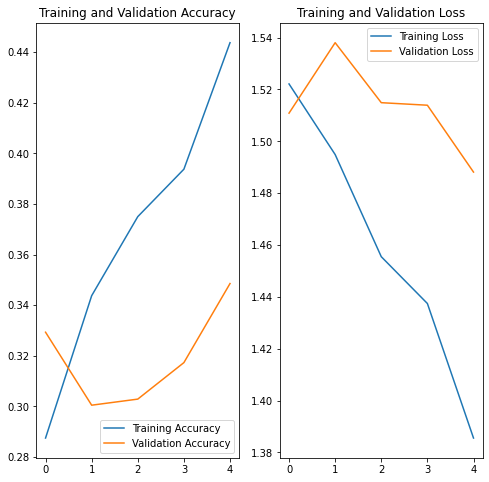

In [12]:
plot_loss(history=history)

# 3. Test the first model

In [7]:
test_path = 'G:/Projects/Gods Classification/Model to train/dataset/Test/*'

In [87]:
test_generator = AugmentedDataGenerator('test',train_mode='normal')

In [88]:
model.evaluate(test_generator)

ValueError: could not broadcast input array from shape (200,200,3) into shape (400,400,3)

# 4. Experiment with Learning Rates

In [8]:
# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

In [83]:
# range of learning rates to tune
hyper_parameters_for_lr = [1, 0.5, 0.1,0.01,0.001]

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    adam = optimizers.Adam(learning_rate=lr, clipnorm=1.)
    
    # model and generators
    model = Sequential([
        layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
        layers.MaxPooling2D(),
        layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])    
    model.compile(loss='categorical_crossentropy',optimizer= adam,
                  metrics=['accuracy'])
    training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=50)
    validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=50)
    model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=1  ========================================
Epoch 1/5
27/27 [==============================] - 47s 2s/step - loss: 1695105664.0000 - accuracy: 0.2199 - val_loss: 4.7392 - val_accuracy: 0.1927
Epoch 2/5
27/27 [==============================] - 30s 1s/step - loss: 4.2362 - accuracy: 0.1748 - val_loss: 6.2577 - val_accuracy: 0.2552
Epoch 3/5
27/27 [==============================] - 30s 1s/step - loss: 2.0543 - accuracy: 0.2350 - val_loss: 1.6083 - val_accuracy: 0.2240
Epoch 4/5
27/27 [==============================] - 31s 1s/step - loss: 1.6296 - accuracy: 0.2164 - val_loss: 1.6148 - val_accuracy: 0.2552
Epoch 5/5
27/27 [==============================] - 31s 1s/step - loss: 1.6255 - accuracy: 0.2488 - val_loss: 1.6866 - val_accuracy: 0.2448


========================================   Checking for LR=0.5  ========================================
Epoch 1/5
27/27 [==============================] - 31s 1s/step - loss: 103946152.000

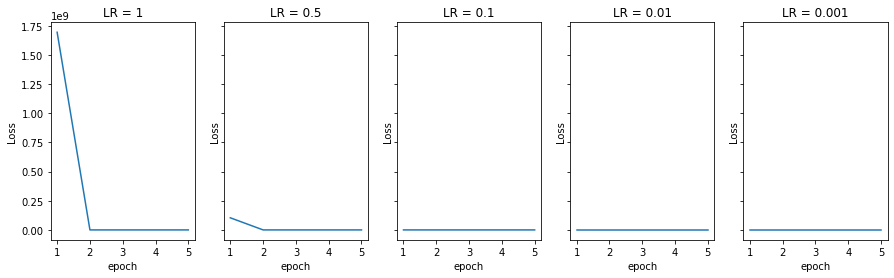

In [84]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1,5, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])
    axes[i].set_title('LR = {}'.format(lr))
    axes[i].set(xlabel='epoch',ylabel='Loss')

### The following learning rates are for a 50 abalation test run for SGD optimizer

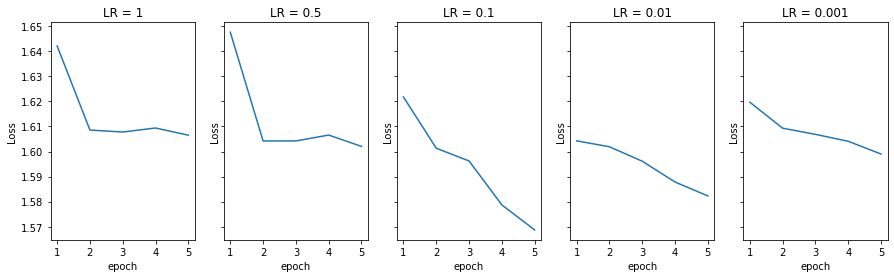
The loss goes down the steepest for learning_rate = 0.1

# 5. Try running model with LR = 0.1

### Set LR = 1 and compile model

In [10]:
sgd = optimizers.SGD(learning_rate=0.1, clipnorm=1.)

In [389]:
model = Sequential([
        layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
        layers.MaxPooling2D(),
        layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])    


model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])

In [390]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_101 (Conv2D)         (None, 46, 46, 64)      

### Train the model

In [391]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
history = model.fit(training_generator, epochs=40, validation_data=validation_generator)

Epoch 1/40
54/54 [==============================] - 58s 1s/step - loss: 1.6095 - accuracy: 0.2407 - val_loss: 1.5950 - val_accuracy: 0.2620
Epoch 2/40
54/54 [==============================] - 57s 1s/step - loss: 1.5929 - accuracy: 0.2668 - val_loss: 1.5719 - val_accuracy: 0.2788
Epoch 3/40
54/54 [==============================] - 57s 1s/step - loss: 1.5706 - accuracy: 0.2795 - val_loss: 1.7312 - val_accuracy: 0.1851
Epoch 4/40
54/54 [==============================] - 58s 1s/step - loss: 1.5642 - accuracy: 0.2963 - val_loss: 1.5479 - val_accuracy: 0.2981
Epoch 5/40
54/54 [==============================] - 56s 1s/step - loss: 1.5224 - accuracy: 0.3356 - val_loss: 1.5080 - val_accuracy: 0.3269
Epoch 6/40
54/54 [==============================] - 65s 1s/step - loss: 1.4919 - accuracy: 0.3432 - val_loss: 1.4865 - val_accuracy: 0.3269
Epoch 7/40
54/54 [==============================] - 77s 1s/step - loss: 1.4924 - accuracy: 0.3582 - val_loss: 1.4714 - val_accuracy: 0.3750
Epoch 8/40
54/54 [==

### View test accuracy

In [285]:
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

In [394]:
model.evaluate(test_generator)

7/7 [==============================] - 8s 1s/step - loss: 0.9936 - accuracy: 0.7500


[0.9935890436172485, 0.75]

### Create a function to choose random images and predict classes

In [339]:
len(test_generator)

7

In [399]:
np.append([1,2,3],[1])

array([1, 2, 3, 1])

In [11]:
def predict_random(model,test_generator,img_classes=img_classes):
    X,y = test_generator[np.random.randint(1,len(test_generator))]
    rand = np.random.randint(1,len(X))
    img = np.float32(X[rand])
    
    prediction = model.predict(np.expand_dims(img,axis=0))
    print(tabulate(np.round(prediction,2)*100,headers=img_classes))
    if img.mean()==0:
        count+=1
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGBA)
    img_classes = img_classes + ['Unknown']
    plt.imshow(img)
    print("Actual = {} ||| Predicted = {}".format(img_classes[np.argmax(y[rand])],img_classes[np.argmax(np.append(prediction,0.5))]))

Actual = Hanuman ||| Predicted = Hanuman


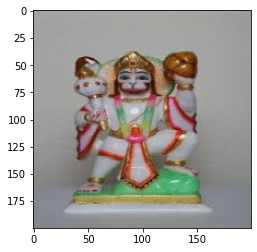

In [399]:
predict_random(model,test_generator)

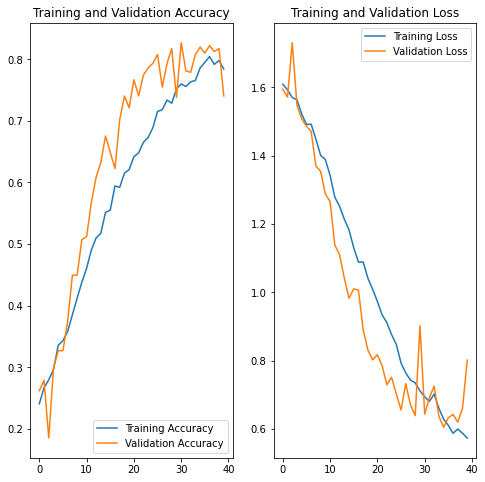

In [396]:
plot_loss(history=history)

### Above curves look okay, the overfitting has been addressed. Time to improve on model with LR decay

# 6. LR decay experiments

### Write function to decay LR

In [9]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.1, decay_rate=0.5, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        self.decay_rate = decay_rate
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * ((self.decay_rate) ** (epoch // self.decay_epoch))
        self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

In [13]:
decay = DecayLR(base_lr=0.1)

### Build Model

In [21]:
sgd = optimizers.SGD()

In [22]:
model = Sequential([
        layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
        layers.MaxPooling2D(),
        layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])    


model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)       

### Train the model

In [25]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=10)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=10)
history = model.fit(training_generator, epochs=20, validation_data=validation_generator,callbacks=[decay])

Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 1.6100 - accuracy: 0.2500 - val_loss: 1.6023 - val_accuracy: 0.2812
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 1.6059 - accuracy: 0.2562 - val_loss: 1.6038 - val_accuracy: 0.2500
Epoch 3/20
5/5 [==============================] - 5s 1s/step - loss: 1.6029 - accuracy: 0.2500 - val_loss: 1.5957 - val_accuracy: 0.2812
Epoch 4/20
5/5 [==============================] - 5s 1s/step - loss: 1.6000 - accuracy: 0.2562 - val_loss: 1.6208 - val_accuracy: 0.1562
Epoch 5/20
5/5 [==============================] - 5s 1s/step - loss: 1.5992 - accuracy: 0.2562 - val_loss: 1.6015 - val_accuracy: 0.2500
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 1.5998 - accuracy: 0.2500 - val_loss: 1.6062 - val_accuracy: 0.2188
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 1.5979 - accuracy: 0.2562 - val_loss: 1.5932 - val_accuracy: 0.2812
Epoch 8/20
5/5 [=========================

### Run experiments on decay rate

In [31]:
# range of learning rates to tune
hyper_parameters_for_lr_decay = [0.4, 0.5, 0.6, 0.7, 0.8]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for decay_rate in hyper_parameters_for_lr_decay:
    print ('\n\n'+'=='*20 + '   Checking for decay={}  '.format(decay_rate) + '=='*20 )
    sgd = optimizers.SGD()
    decay = DecayLR(base_lr=0.1,decay_rate=decay_rate)
    # model and generators
    model = Sequential([
        layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
        layers.MaxPooling2D(),
        layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])    
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=50)
    validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=50)
    model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[history,decay])
    
    # plot loss history
    plot_data[decay_rate] = history.losses



========================================   Checking for decay=0.4  ========================================
Epoch 1/5
27/27 [==============================] - 27s 974ms/step - loss: 1.6329 - accuracy: 0.2396 - val_loss: 1.6012 - val_accuracy: 0.2552
Epoch 2/5
27/27 [==============================] - 31s 1s/step - loss: 1.5980 - accuracy: 0.2604 - val_loss: 1.5976 - val_accuracy: 0.2552
Epoch 3/5
27/27 [==============================] - 27s 1s/step - loss: 1.5953 - accuracy: 0.2546 - val_loss: 1.5920 - val_accuracy: 0.2500
Epoch 4/5
27/27 [==============================] - 28s 1s/step - loss: 1.5869 - accuracy: 0.2558 - val_loss: 1.5929 - val_accuracy: 0.2292
Epoch 5/5
27/27 [==============================] - 27s 1s/step - loss: 1.5804 - accuracy: 0.2662 - val_loss: 1.5795 - val_accuracy: 0.2604


========================================   Checking for decay=0.5  ========================================
Epoch 1/5
27/27 [==============================] - 29s 1s/step - loss: 1.9130 - ac

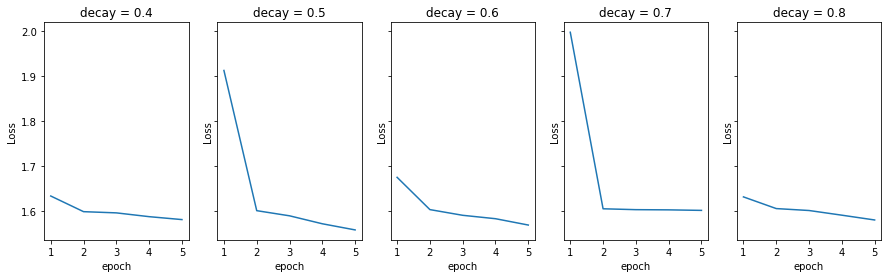

In [34]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1,5, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.8]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])
    axes[i].set_title('decay = {}'.format(lr))
    axes[i].set(xlabel='epoch',ylabel='Loss')

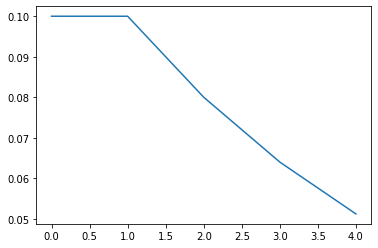

In [35]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

### This decay experiment doesn't make sense

# 7. Add checkpoint

In [64]:
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [65]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.1,decay_rate=0.5,decay_epoch=40)

In [66]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [67]:
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])


### Train model

In [69]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
history = model.fit(training_generator, epochs=100, validation_data=validation_generator,callbacks=[decay,checkpoint])

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.6021 - accuracy: 0.2535
Epoch 00001: val_accuracy did not improve from 0.34375
54/54 [==============================] - 48s 877ms/step - loss: 1.6021 - accuracy: 0.2535 - val_loss: 1.5824 - val_accuracy: 0.3125
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 1.5928 - accuracy: 0.2639
Epoch 00002: val_accuracy did not improve from 0.34375
54/54 [==============================] - 49s 915ms/step - loss: 1.5928 - accuracy: 0.2639 - val_loss: 1.6059 - val_accuracy: 0.2500
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.2558
Epoch 00003: val_accuracy did not improve from 0.34375
54/54 [==============================] - 50s 929ms/step - loss: 1.5837 - accuracy: 0.2558 - val_loss: 1.6041 - val_accuracy: 0.2812
Epoch 4/100
54/54 [==============================] - ETA: 0s - loss: 1.5637 - accuracy: 0.2778
Epoch 00004: val_accuracy did not improve from 0.34375
54/5

Epoch 29/100
54/54 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.6944
Epoch 00029: val_accuracy improved from 0.84375 to 0.87500, saving model to models\best_model.hdf5
54/54 [==============================] - 48s 885ms/step - loss: 0.8322 - accuracy: 0.6944 - val_loss: 0.5489 - val_accuracy: 0.8750
Epoch 30/100
54/54 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6933
Epoch 00030: val_accuracy did not improve from 0.87500
54/54 [==============================] - 47s 866ms/step - loss: 0.8717 - accuracy: 0.6933 - val_loss: 0.8068 - val_accuracy: 0.7500
Epoch 31/100
54/54 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.6921
Epoch 00031: val_accuracy improved from 0.87500 to 0.90625, saving model to models\best_model.hdf5
54/54 [==============================] - 47s 864ms/step - loss: 0.8674 - accuracy: 0.6921 - val_loss: 0.5157 - val_accuracy: 0.9062
Epoch 32/100
54/54 [==============================] - ETA: 0s -

Epoch 58/100
54/54 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8414
Epoch 00058: val_accuracy did not improve from 0.96875
54/54 [==============================] - 48s 874ms/step - loss: 0.4481 - accuracy: 0.8414 - val_loss: 0.6346 - val_accuracy: 0.8125
Epoch 59/100
54/54 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8455
Epoch 00059: val_accuracy did not improve from 0.96875
54/54 [==============================] - 49s 904ms/step - loss: 0.4297 - accuracy: 0.8455 - val_loss: 0.5159 - val_accuracy: 0.8750
Epoch 60/100
54/54 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.8275
Epoch 00060: val_accuracy did not improve from 0.96875
54/54 [==============================] - 48s 882ms/step - loss: 0.5021 - accuracy: 0.8275 - val_loss: 0.6366 - val_accuracy: 0.8750
Epoch 61/100
54/54 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.8368
Epoch 00061: val_accuracy did not improve from 0.96875


Epoch 87/100
54/54 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9045
Epoch 00087: val_accuracy did not improve from 0.96875
54/54 [==============================] - 47s 868ms/step - loss: 0.2848 - accuracy: 0.9045 - val_loss: 0.4307 - val_accuracy: 0.8438
Epoch 88/100
54/54 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.8987
Epoch 00088: val_accuracy did not improve from 0.96875
54/54 [==============================] - 47s 868ms/step - loss: 0.2789 - accuracy: 0.8987 - val_loss: 0.6115 - val_accuracy: 0.8750
Epoch 89/100
54/54 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9103
Epoch 00089: val_accuracy did not improve from 0.96875
54/54 [==============================] - 47s 864ms/step - loss: 0.2586 - accuracy: 0.9103 - val_loss: 0.5386 - val_accuracy: 0.8750
Epoch 90/100
54/54 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9172
Epoch 00090: val_accuracy did not improve from 0.96875


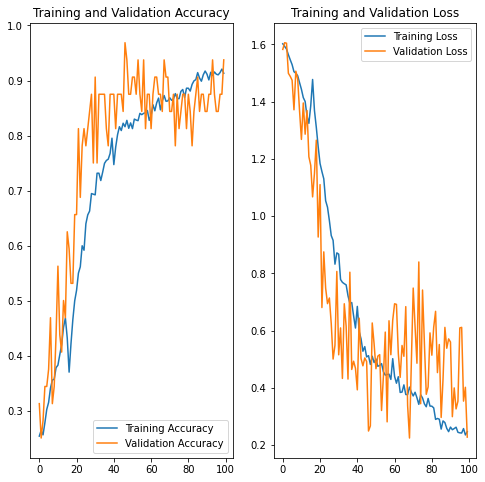

In [70]:
plot_loss(history)

In [78]:
model.evaluate(validation_generator)

13/13 [==============================] - 7s 555ms/step - loss: 0.6728 - accuracy: 0.8438


[0.6727526783943176, 0.84375]

### Function to get prediction matrix passing in model and dataset

In [596]:
import pandas as pd

In [599]:
pd.get_dummies(1,columns=[1,2,3,4,5])


,1
0,1


In [600]:
a = np.array([1,2,3])
a[1]+=1

In [892]:
def get_predictions(model,test_generator,thresh=None):
    y_true = []
    y_pred = []
    y_pred_prob = []
    if thresh is not None:
        if type(thresh)==float:
            thresh = [thresh]*5
        thresh = np.array(thresh)
        preference = np.argsort(thresh)[::-1]

    for X in test_generator.labels:
        img = cv2.imread(X)
        img = np.expand_dims(preprocess_img(img,mode='test'),axis=0)
        prediction = model.predict(img)
        y_pred_prob.append(prediction[0])
        if thresh is not None:
            if np.where(prediction[0]>thresh)[0].size==0:
                y_pred.append(len(prediction[0]))
            for value in preference:
                if value in np.where(prediction[0]>thresh)[0]:
                    y_pred.append(value)
                    flag = 1
                    break
            
        else:
            y_pred.append(np.argmax(prediction))
        y_true.append(test_generator.labels[X])
    return y_true,y_pred,y_pred_prob

In [136]:
y_true,y_pred = get_predictions(model,test_generator)

### Create the confusion matrix

In [137]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

In [138]:
confusion

array([[31,  2,  6,  3,  7],
       [ 2, 35,  5,  6,  2],
       [ 1,  0, 43,  3,  3],
       [ 4,  2,  1, 40,  2],
       [ 0,  0,  2,  0, 46]], dtype=int64)

### Function to display confusion matrix in colour map

In [1275]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    if normalize:
        thresh=0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        print("i: {},j:{} ,cm:{} ,thresh:{}".format(i,j,cm[i,j],thresh))
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


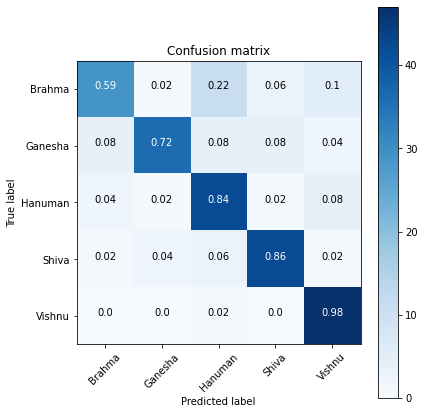

In [129]:
plot_confusion_matrix(confusion,img_classes)

# 8. Retrieve best model using checkpoint

In [130]:
checkpoint_model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    

In [131]:
checkpoint_model.load_weights('models/best_model.hdf5')

In [133]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

array([[8.4187761e-03, 4.9993508e-03, 1.9316899e-03, 5.4307538e-03,
        9.7921950e-01],
       [1.4227659e-01, 1.1599625e-02, 5.3338416e-02, 9.4258925e-03,
        7.8335947e-01],
       [2.2291970e-02, 2.1482747e-04, 9.1754436e-01, 1.3777670e-03,
        5.8571111e-02],
       ...,
       [1.2291526e-02, 1.9344091e-03, 3.2038480e-02, 2.2025115e-04,
        9.5351529e-01],
       [1.6145514e-02, 4.5355279e-02, 1.4886236e-01, 7.8704309e-01,
        2.5938535e-03],
       [2.0029616e-01, 1.9600542e-01, 2.1374781e-01, 1.0913672e-01,
        2.8081390e-01]], dtype=float32)

In [164]:
y_true,y_pred = get_predictions(model,validation_generator)

In [165]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

Normalized confusion matrix
ACCURACY: 0.83


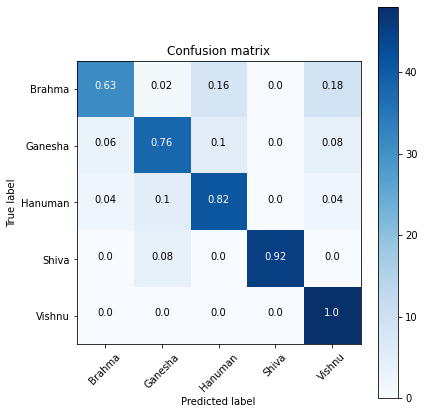

In [288]:
plot_confusion_matrix(confusion,img_classes,normalize=True)
accuracy = confusion.trace()/confusion.sum()
print("ACCURACY: {:.2f}".format(accuracy))

# 9. Weight your losses based on the confusion matrix

### A technique to get weights based on previous confusion matrix

In [187]:
def get_weights(confusion,factor=5):
    bin_weights = 5*confusion/confusion.sum(axis=1)+1
    np.fill_diagonal(bin_weights,1)
    return bin_weights

In [188]:
weight = get_weights(confusion)

In [190]:
weight

array([[1.        , 1.12987013, 1.34482759, 1.375     , 1.27027027],
       [1.0617284 , 1.        , 1.17241379, 1.375     , 1.13513514],
       [1.30864198, 1.06493506, 1.        , 1.25      , 1.31531532],
       [1.30864198, 1.32467532, 1.63218391, 1.        , 1.09009009],
       [1.30864198, 1.25974026, 1.74712644, 1.3125    , 1.        ]])

### Function to configure weights into entropy

In [13]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = tf.keras.backend.zeros_like(y_pred[:, 0])
    y_pred_max = tf.keras.backend.max(y_pred, axis=1)
    y_pred_max = tf.keras.backend.reshape(y_pred_max, (tf.keras.backend.shape(y_pred)[0], 1))
    y_pred_max_mat = tf.keras.backend.cast(tf.keras.backend.equal(y_pred, y_pred_max), tf.keras.backend.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = tf.keras.backend.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

#### Weighted Losses

In [204]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

#### Checkpoint

In [205]:
filepath = 'models/best_model_run_2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#### LR Decay

In [206]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.1,decay_rate=0.5,decay_epoch=40)

In [207]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [208]:
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

### Run model

In [210]:
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

model.fit(training_generator, epochs=10, validation_data=validation_generator,callbacks=[checkpoint])

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.9110 - accuracy: 0.2454
Epoch 00001: val_loss improved from inf to 2.22173, saving model to models\best_model_run_2.hdf5
27/27 [==============================] - 28s 1s/step - loss: 1.9110 - accuracy: 0.2454 - val_loss: 2.2217 - val_accuracy: 0.2135
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.9084 - accuracy: 0.2708
Epoch 00002: val_loss improved from 2.22173 to 1.95466, saving model to models\best_model_run_2.hdf5
27/27 [==============================] - 28s 1s/step - loss: 1.9084 - accuracy: 0.2708 - val_loss: 1.9547 - val_accuracy: 0.2292
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 1.8981 - accuracy: 0.2627
Epoch 00003: val_loss did not improve from 1.95466
27/27 [==============================] - 29s 1s/step - loss: 1.8981 - accuracy: 0.2627 - val_loss: 2.0301 - val_accuracy: 0.1979
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 1.8922 - accur

In [297]:
y_true,y_pred = get_predictions(model,validation_generator)

In [298]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

Normalized confusion matrix
ACCURACY: 0.21


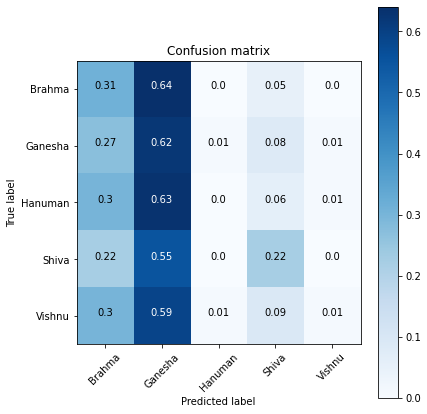

In [299]:
plot_confusion_matrix(confusion,img_classes,normalize=True)
accuracy = confusion.trace()/confusion.sum()
print("ACCURACY: {:.2f}".format(accuracy))

# 10. The final model

#### Weighted Losses

In [14]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

NameError: name 'weight' is not defined

#### Checkpoint

In [10]:
filepath = 'models/model_higher_res_2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#### LR Decay

In [11]:
num_classes = len(img_classes)
num_channels = 3

In [12]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.05,decay_rate=0.5,decay_epoch=20)

In [14]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 98, 98, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1

In [16]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=sgd,
              metrics=['accuracy'])

### Run model

In [ ]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

history = model.fit(training_generator, epochs=200, validation_data=validation_generator,callbacks=[decay,checkpoint])

Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.2431
Epoch 00001: val_loss improved from inf to 1.59979, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 218s 4s/step - loss: 1.6915 - accuracy: 0.2431 - val_loss: 1.5998 - val_accuracy: 0.2620
Epoch 2/200
54/54 [==============================] - ETA: 0s - loss: 1.5988 - accuracy: 0.2558
Epoch 00002: val_loss improved from 1.59979 to 1.59592, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 214s 4s/step - loss: 1.5988 - accuracy: 0.2558 - val_loss: 1.5959 - val_accuracy: 0.2572
Epoch 3/200
54/54 [==============================] - ETA: 0s - loss: 1.5994 - accuracy: 0.2529
Epoch 00003: val_loss improved from 1.59592 to 1.59374, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 223s 4s/step - loss: 1.5994 - accuracy: 0.2529 - val_loss: 1.5937 - val_accuracy: 0.2596
Epoch 4/200
54/54 [=

54/54 [==============================] - 236s 4s/step - loss: 1.0347 - accuracy: 0.6128 - val_loss: 0.8720 - val_accuracy: 0.7284
Epoch 28/200
54/54 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.6198
Epoch 00028: val_loss did not improve from 0.87201
54/54 [==============================] - 235s 4s/step - loss: 1.0056 - accuracy: 0.6198 - val_loss: 0.8728 - val_accuracy: 0.7019
Epoch 29/200
54/54 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.6395
Epoch 00029: val_loss improved from 0.87201 to 0.87035, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 237s 4s/step - loss: 0.9661 - accuracy: 0.6395 - val_loss: 0.8704 - val_accuracy: 0.7067
Epoch 30/200
54/54 [==============================] - ETA: 0s - loss: 0.9488 - accuracy: 0.6586
Epoch 00030: val_loss improved from 0.87035 to 0.82166, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 237s 4s/step - loss: 0.9

Epoch 55/200
54/54 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7847
Epoch 00055: val_loss did not improve from 0.52365
54/54 [==============================] - 238s 4s/step - loss: 0.5757 - accuracy: 0.7847 - val_loss: 0.5315 - val_accuracy: 0.8173
Epoch 56/200
54/54 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.8061
Epoch 00056: val_loss improved from 0.52365 to 0.50766, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 239s 4s/step - loss: 0.5484 - accuracy: 0.8061 - val_loss: 0.5077 - val_accuracy: 0.8293
Epoch 57/200
54/54 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7899
Epoch 00057: val_loss improved from 0.50766 to 0.50490, saving model to models\model_higher_res_2.hdf5
54/54 [==============================] - 238s 4s/step - loss: 0.5757 - accuracy: 0.7899 - val_loss: 0.5049 - val_accuracy: 0.8077
Epoch 58/200
54/54 [==============================] - ETA: 0s - l

Epoch 84/200
54/54 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8397
Epoch 00084: val_loss did not improve from 0.45320
54/54 [==============================] - 242s 4s/step - loss: 0.4357 - accuracy: 0.8397 - val_loss: 0.5020 - val_accuracy: 0.8077
Epoch 85/200
54/54 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8443
Epoch 00085: val_loss did not improve from 0.45320
54/54 [==============================] - 241s 4s/step - loss: 0.4356 - accuracy: 0.8443 - val_loss: 0.5030 - val_accuracy: 0.8221
Epoch 86/200
54/54 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8443
Epoch 00086: val_loss did not improve from 0.45320
54/54 [==============================] - 241s 4s/step - loss: 0.4274 - accuracy: 0.8443 - val_loss: 0.5087 - val_accuracy: 0.8077
Epoch 87/200
54/54 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8368
Epoch 00087: val_loss did not improve from 0.45320
54/54 [===============

Epoch 114/200
54/54 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8692
Epoch 00114: val_loss did not improve from 0.45320
54/54 [==============================] - 245s 5s/step - loss: 0.3591 - accuracy: 0.8692 - val_loss: 0.4946 - val_accuracy: 0.8125
Epoch 115/200
54/54 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8611
Epoch 00115: val_loss did not improve from 0.45320
54/54 [==============================] - 245s 5s/step - loss: 0.4061 - accuracy: 0.8611 - val_loss: 0.5040 - val_accuracy: 0.8245
Epoch 116/200
54/54 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8600
Epoch 00116: val_loss did not improve from 0.45320
54/54 [==============================] - 246s 5s/step - loss: 0.3889 - accuracy: 0.8600 - val_loss: 0.4994 - val_accuracy: 0.8293
Epoch 117/200
54/54 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8675
Epoch 00117: val_loss did not improve from 0.45320
54/54 [===========

Epoch 144/200
54/54 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8698
Epoch 00144: val_loss did not improve from 0.45320
54/54 [==============================] - 271s 5s/step - loss: 0.3636 - accuracy: 0.8698 - val_loss: 0.4947 - val_accuracy: 0.8077
Epoch 145/200
54/54 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8791
Epoch 00145: val_loss did not improve from 0.45320
54/54 [==============================] - 274s 5s/step - loss: 0.3341 - accuracy: 0.8791 - val_loss: 0.4769 - val_accuracy: 0.8173
Epoch 146/200
54/54 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8519
Epoch 00146: val_loss did not improve from 0.45320
54/54 [==============================] - 261s 5s/step - loss: 0.3889 - accuracy: 0.8519 - val_loss: 0.5137 - val_accuracy: 0.8077
Epoch 147/200
42/54 [======================>.......] - ETA: 57s - loss: 0.3770 - accuracy: 0.8676 

KeyboardInterrupt: 

In [ ]:
plot_loss(history)

### Evaluate Test

In [262]:
test_generator = AugmentedDataGenerator(mode='test', ablation=None)

In [263]:
model.evaluate(test_generator)

7/7 [==============================] - 4s 585ms/step - loss: 0.7556 - accuracy: 0.8170


[0.7555773854255676, 0.8169642686843872]

In [285]:
y_true,y_pred = get_predictions(model,test_generator)

In [286]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

### Confusion Matrix

Normalized confusion matrix
ACCURACY: 0.83


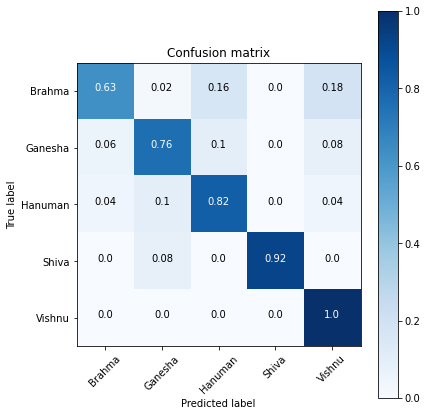

In [291]:
plot_confusion_matrix(confusion,img_classes)
accuracy = confusion.trace()/confusion.sum()
print("ACCURACY: {:.2f}".format(accuracy))

### Load model from checkpoint

In [1247]:
checkpoint_model_2 = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    

In [1248]:
checkpoint_model_2.load_weights('models/best_model_run_2.hdf5')

In [1251]:
checkpoint_model_2.compile(loss=tf.losses.CategoricalCrossentropy(),optimizer = sgd,metrics = ['accuracy'])

In [1252]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

In [1255]:
checkpoint_model_2.evaluate(validation_generator)

13/13 [==============================] - 9s 650ms/step - loss: 0.4905 - accuracy: 0.8462


[0.4905305504798889, 0.8461538553237915]

In [1269]:
y_true,y_pred,y_pred_prob = get_predictions(checkpoint_model_2,test_generator,thresh=0.5)

### Confusion

In [1270]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\1605347349.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
i: 0,j:0 ,cm:0.65 ,thresh:0.5
i: 0,j:1 ,cm:0.0 ,thresh:0.5
i: 0,j:2 ,cm:0.04 ,thresh:0.5
i: 0,j:3 ,cm:0.04 ,thresh:0.5
i: 0,j:4 ,cm:0.12 ,thresh:0.5
i: 0,j:5 ,cm:0.14 ,thresh:0.5
i: 1,j:0 ,cm:0.02 ,thresh:0.5
i: 1,j:1 ,cm:0.7 ,thresh:0.5
i: 1,j:2 ,cm:0.02 ,thresh:0.5
i: 1,j:3 ,cm:0.02 ,thresh:0.5
i: 1,j:4 ,cm:0.02 ,thresh:0.5
i: 1,j:5 ,cm:0.22 ,thresh:0.5
i: 2,j:0 ,cm:0.06 ,thresh:0.5
i: 2,j:1 ,cm:0.02 ,thresh:0.5
i: 2,j:2 ,cm:0.82 ,thresh:0.5
i: 2,j:3 ,cm:0.0 ,thresh:0.5
i: 2,j:4 ,cm:0.02 ,thresh:0.5
i: 2,j:5 ,cm:0.08 ,thresh:0.5
i: 3,j:0 ,cm:0.0 ,thresh:0.5
i: 3,j:1 ,cm:0.04 ,thresh:0.5
i: 3,j:2 ,cm:0.0 ,thresh:0.5
i: 3,j:3 ,cm:0.92 ,thresh:0.5
i: 3,j:4 ,cm:0.0 ,thresh:0.5
i: 3,j:5 ,cm:0.04 ,thresh:0.5
i: 4,j:0 ,cm:0.0 ,thresh:0.5
i: 4,j:1 ,cm:0.0 ,thresh:0.5
i: 4,j:2 ,cm:0.0 ,thresh:0.5
i: 4,j:3 ,cm:0.0 ,thresh:0.5
i: 4,j:4 ,cm:1.0 ,thresh:0.5
i: 4,j:5 ,cm:0.0 ,thresh:0.5
i: 5,j:0 ,cm:nan ,thresh:0.5
i: 5,j:1 ,cm:nan ,thresh:0.5
i: 5,j:2 ,cm:nan ,thresh:0

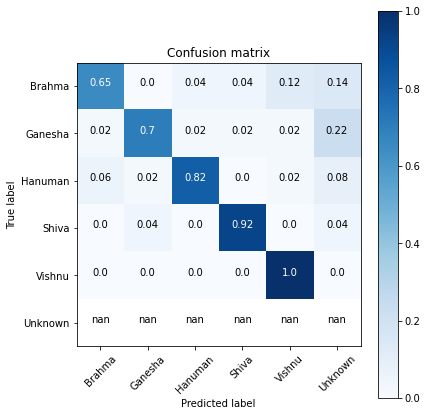

In [1276]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

### ROC curve

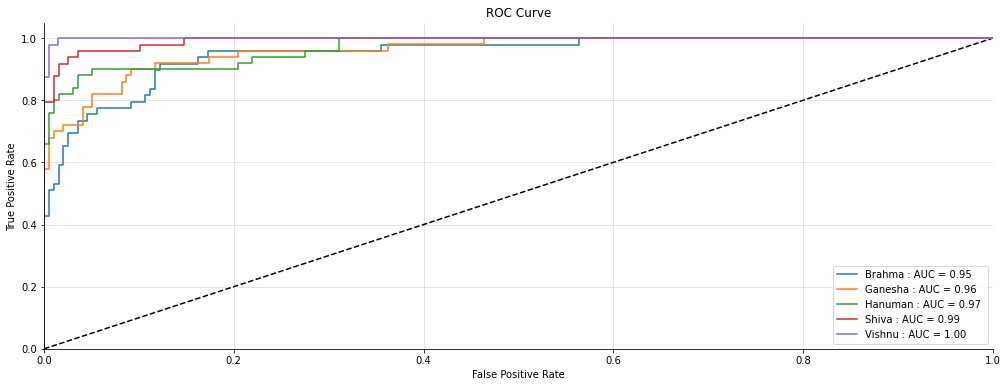

In [1272]:
thresh,ix = plot_multiclass_roc(y_pred_prob=y_pred_prob,y_test=y_true)

### Save the model


In [1279]:
checkpoint_model_2.save('models/final_model.h5')

### Load and check if it works

In [1280]:
new_model = tf.keras.models.load_model('models/final_model.h5')

In [1281]:
new_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 99, 99, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_107 (Conv2D)         (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 23, 23, 64)     

In [1282]:
new_model.get_weights()

[array([[[[-0.170113  ,  0.05342141,  0.07493592, -0.07954379,
           -0.03449659,  0.33219296,  0.02652499, -0.03773995,
            0.15904263,  0.02516574,  0.24286197,  0.01484984,
            0.06665435, -0.00567722, -0.00454135,  0.1098216 ,
           -0.12913446,  0.31239694, -0.19787435, -0.0695671 ,
            0.36001882, -0.09678905, -0.17261137, -0.16818869,
           -0.38031003,  0.13094866, -0.12746826, -0.04981598,
           -0.10404792, -0.08969888, -0.32394016,  0.07305656],
          [-0.11913045, -0.12777813,  0.09299367,  0.11418672,
           -0.0596819 ,  0.01774398, -0.02383719,  0.04573955,
            0.21772894, -0.09644035,  0.03018578, -0.14286277,
           -0.03644126,  0.11675389, -0.3507173 , -0.11083023,
            0.07408793,  0.09304868,  0.09560549,  0.01610008,
            0.33637553, -0.24545214, -0.3200752 , -0.07488761,
            0.2296941 , -0.10388644, -0.12621471, -0.12996037,
            0.05687657, -0.10870907,  0.09679853,  0.0

In [1283]:
new_model.optimizer

---
# A few experiments were conducted after the final model
---

# 11. Model with 3 Dropouts and early stopping

#### Weighted Losses

In [1056]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

#### Checkpoint

In [293]:
filepath = 'models/best_model_run_3.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#### LR Decay

In [228]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.05,decay_rate=0.5,decay_epoch=40)

#### Early Stopping

In [295]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10,
)

#### Model

In [316]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [317]:
model.compile(loss=ncce, optimizer=sgd,
              metrics=['accuracy'])

### Run model

In [318]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

history = model.fit(training_generator, epochs=100, validation_data=validation_generator,callbacks=[decay,checkpoint,early_stopping])

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.9055 - accuracy: 0.2541
Epoch 00001: val_loss did not improve from 0.66592
54/54 [==============================] - 58s 1s/step - loss: 1.9055 - accuracy: 0.2541 - val_loss: 2.2152 - val_accuracy: 0.2043
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 1.8953 - accuracy: 0.2708
Epoch 00002: val_loss did not improve from 0.66592
54/54 [==============================] - 58s 1s/step - loss: 1.8953 - accuracy: 0.2708 - val_loss: 1.9716 - val_accuracy: 0.3029
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.8792 - accuracy: 0.2876
Epoch 00003: val_loss did not improve from 0.66592
54/54 [==============================] - 59s 1s/step - loss: 1.8792 - accuracy: 0.2876 - val_loss: 1.8491 - val_accuracy: 0.2861
Epoch 4/100
54/54 [==============================] - ETA: 0s - loss: 1.8564 - accuracy: 0.3084
Epoch 00004: val_loss did not improve from 0.66592
54/54 [======================

Epoch 31/100
54/54 [==============================] - ETA: 0s - loss: 0.7160 - accuracy: 0.7899
Epoch 00031: val_loss did not improve from 0.66056
54/54 [==============================] - 52s 960ms/step - loss: 0.7160 - accuracy: 0.7899 - val_loss: 0.6778 - val_accuracy: 0.8149
Epoch 32/100
54/54 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7946
Epoch 00032: val_loss improved from 0.66056 to 0.62574, saving model to models\best_model_run_3.hdf5
54/54 [==============================] - 53s 974ms/step - loss: 0.7096 - accuracy: 0.7946 - val_loss: 0.6257 - val_accuracy: 0.8558
Epoch 33/100
54/54 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.8160
Epoch 00033: val_loss improved from 0.62574 to 0.59122, saving model to models\best_model_run_3.hdf5
54/54 [==============================] - 53s 986ms/step - loss: 0.6647 - accuracy: 0.8160 - val_loss: 0.5912 - val_accuracy: 0.8510
Epoch 34/100
54/54 [==============================] - ETA: 0s -

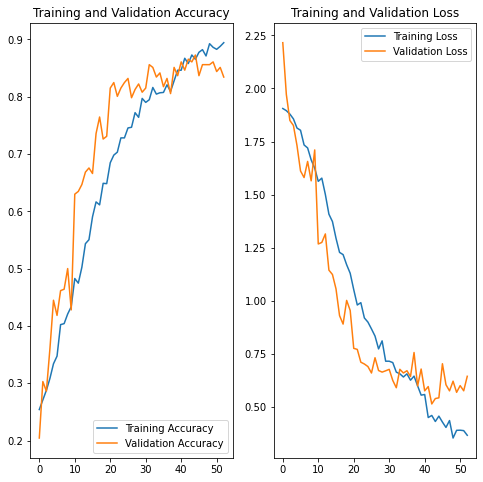

In [319]:
plot_loss(history)

### Evaluate Test

In [320]:
test_generator = AugmentedDataGenerator(mode='test', ablation=None)

In [321]:
model.evaluate(test_generator)

7/7 [==============================] - 4s 541ms/step - loss: 0.7282 - accuracy: 0.8214


[0.7281551361083984, 0.8214285969734192]

In [322]:
y_true,y_pred = get_predictions(model,test_generator)

In [323]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

### Confusion Matrix

Normalized confusion matrix
ACCURACY: 0.81


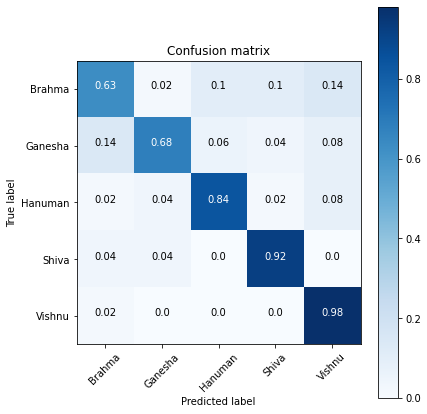

In [324]:
plot_confusion_matrix(confusion,img_classes)
accuracy = confusion.trace()/confusion.sum()
print("ACCURACY: {:.2f}".format(accuracy))

### Checkpoint

In [325]:
checkpoint_model_3 = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    

In [326]:
checkpoint_model_3.load_weights('models/best_model_run_3.hdf5')

In [327]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

In [621]:
y_true,y_pred,y_pred_prob = get_predictions(checkpoint_model_3,test_generator)

In [532]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

### Model 1

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\598330600.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
Accuracy: 0.793 ||| Normalized Accuracy: 0.886


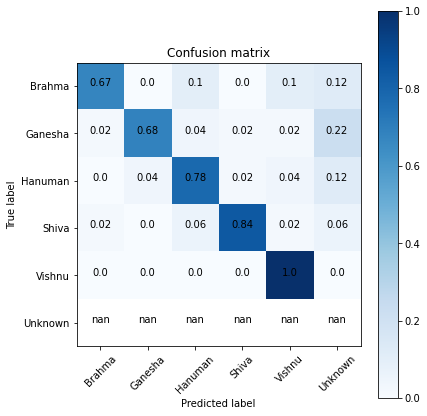

In [530]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

### Model 2

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\598330600.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
Accuracy: 0.817 ||| Normalized Accuracy: 0.905


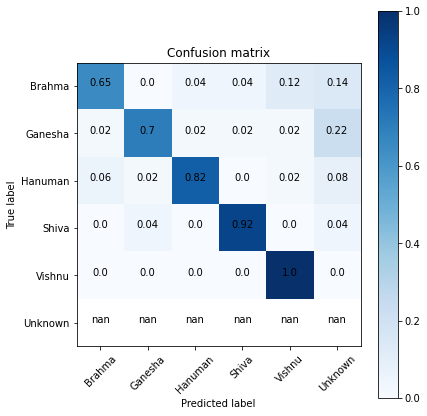

In [527]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

### Model 3

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\598330600.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
Accuracy: 0.789 ||| Normalized Accuracy: 0.874


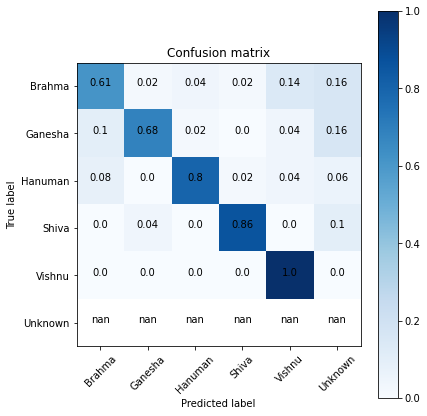

In [534]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

# 12. ROC AUC callback

### Add ROC AUC score callback

In [39]:
class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

### Plot ROC

In [40]:
def plot_multiclass_roc(y_pred_prob, y_test, n_classes=5, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    ix = []
    class_len=[]
    best_thresh = dict()
    thresh = dict()
    roc_auc = dict()
    y_pred_prob = np.transpose(np.array(y_pred_prob))
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test_dummies[:, i], y_pred_prob[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ix.append(np.argmax(np.array(tpr[i]) * (1-np.array(fpr[i]))))
#        best_thresh[i] = thresh[i][ix]

    #roc_auc_val = roc_auc_score(y_test_dummies, np.transpose(y_pred_prob))
    #print(roc_auc_val)
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s : AUC = %0.2f ' % ( img_classes[i],roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    return thresh,ix

In [835]:
y_true,y_pred,y_pred_prob = get_predictions(checkpoint_model_2,test_generator=training_generator)

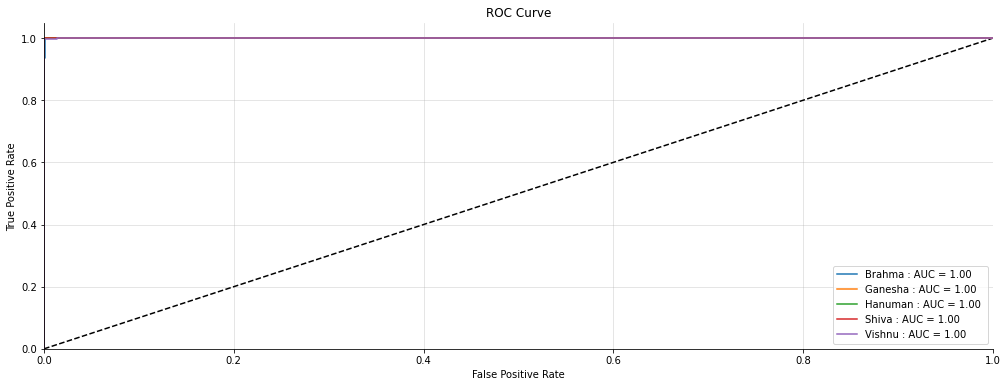

In [836]:
thresh,ix = plot_multiclass_roc(y_pred_prob=y_pred_prob,y_test=y_true)

In [839]:
best_thresh = []
for i in range(5):
    best_thresh.append(thresh[i][ix[i]])

In [840]:
best_thresh

[0.5458164, 0.46593595, 0.33478627, 0.43716034, 0.55201685]

# 13. Get prediction with thresholds

In [828]:
y_true_2,y_pred_2,y_pred_prob_2 = get_predictions(checkpoint_model_2,test_generator=validation_generator,thresh=(best_thresh))

In [843]:
y_pred_2.count(5)

5

In [841]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

Normalized confusion matrix
Accuracy: 0.999 ||| Normalized Accuracy: 0.999


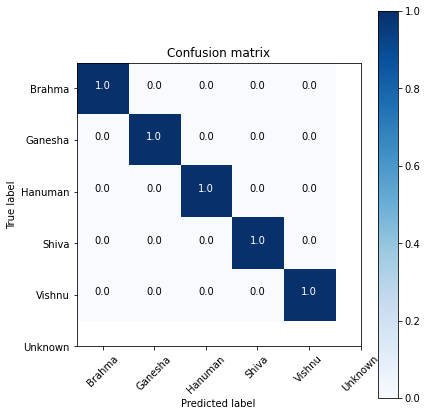

In [842]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

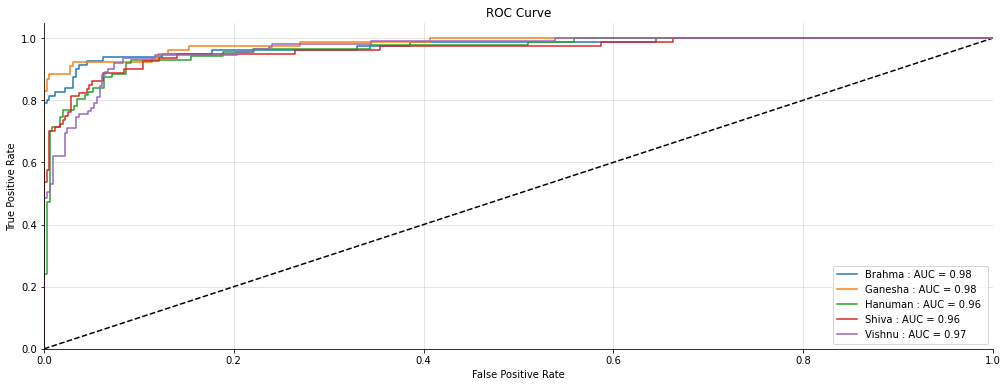

In [813]:
thresh,ix = plot_multiclass_roc(y_pred_prob=y_pred_prob,y_test=y_true)

# 14. Run with ROC AUC callback

#### Weighted Losses

In [1063]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

#### Checkpoint

In [927]:
filepath = 'models/best_model_run_4_loss.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### LR Decay

In [1059]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.01,decay_rate=0.5,decay_epoch=10)

#### Early Stopping

In [1066]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20,
)

#### Log AUC

In [929]:
auc_logger = roc_callback()

#### Model

In [930]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [1064]:
model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=sgd,
              metrics=['accuracy'])

### Run model

In [1067]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

history = model.fit(training_generator, epochs=100, validation_data=validation_generator,callbacks=[auc_logger,decay,checkpoint,early_stopping])

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.8119
Val AUC for epoch0: 0.9658311835393121

Epoch 00001: val_accuracy did not improve from 0.87019
54/54 [==============================] - 63s 1s/step - loss: 0.5603 - accuracy: 0.8119 - val_loss: 0.5049 - val_accuracy: 0.8606 - val_auc: 0.9658
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8137
Val AUC for epoch1: 0.9672270077287353

Epoch 00002: val_accuracy did not improve from 0.87019
54/54 [==============================] - 62s 1s/step - loss: 0.5294 - accuracy: 0.8137 - val_loss: 0.4778 - val_accuracy: 0.8678 - val_auc: 0.9672
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.8409
Val AUC for epoch2: 0.9672596817546284

Epoch 00003: val_accuracy did not improve from 0.87019
54/54 [==============================] - 63s 1s/step - loss: 0.4653 - accuracy: 0.8409 - val_loss: 0.5008 - val_accuracy: 0.8462 - val_a

KeyboardInterrupt: 

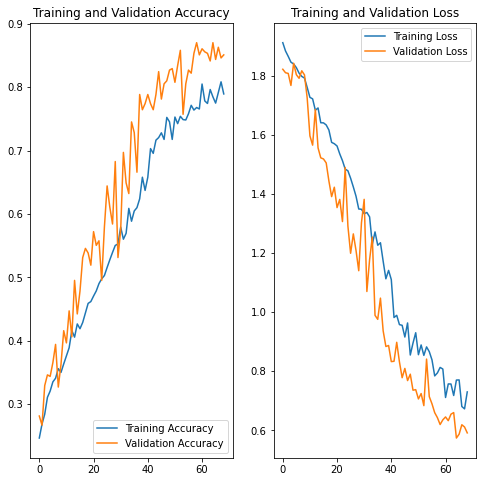

In [934]:
plot_loss(history)

In [1069]:
model.evaluate(test_generator)

7/7 [==============================] - 5s 763ms/step - loss: 0.5473 - accuracy: 0.8348


[0.5473123788833618, 0.8348214030265808]

### Checkpoint

In [1070]:
checkpoint_model_4 = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    

In [1089]:
checkpoint_model_4.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=sgd,
              metrics=['accuracy'])

In [1090]:
checkpoint_model_4.load_weights('models/best_model_run_4_loss.hdf5')

In [1215]:
checkpoint_model_4.evaluate(test_generator)

7/7 [==============================] - 4s 517ms/step - loss: 0.5565 - accuracy: 0.8304


[0.5564867854118347, 0.8303571343421936]

In [1216]:
checkpoint_model_4.save?

In [1094]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

In [1211]:
y_true,y_pred,y_pred_prob = get_predictions(checkpoint_model_2,test_generator,thresh=0.45)

In [1180]:
y_true_2,y_pred_2,y_pred_prob_2 = get_predictions(checkpoint_model_2,validation_generator,thresh=0.68)

### Confusion

In [1212]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\598330600.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
Accuracy: 0.821 ||| Normalized Accuracy: 0.878


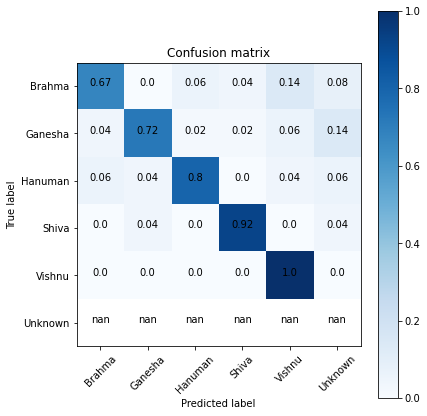

In [1213]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

### ROC curve

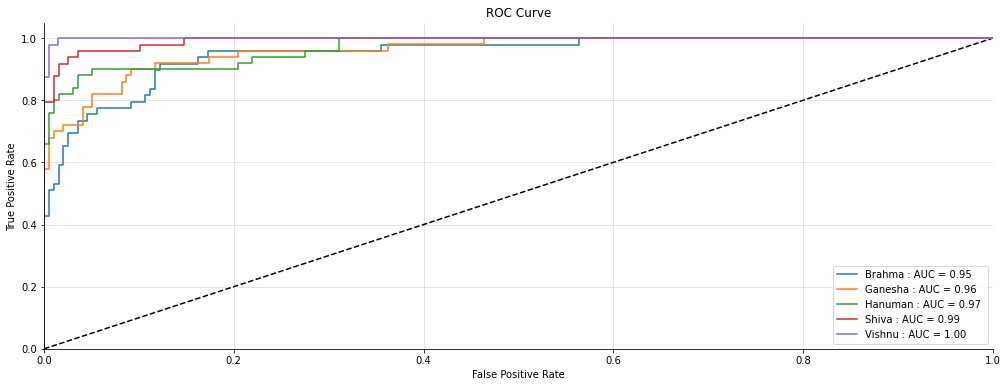

In [963]:
thresh,ix = plot_multiclass_roc(y_pred_prob=y_pred_prob_2,y_test=y_true_2)

# 15. Regularization

#### Weighted Losses

In [48]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

NameError: name 'weight' is not defined

#### Checkpoint

In [227]:
filepath = 'models/lambda_experiments.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### LR Decay

In [228]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.1,decay_rate=0.5,decay_epoch=20)

#### Early Stopping

In [229]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.02, patience=20,
)

#### Log AUC

In [929]:
auc_logger = roc_callback()

#### Model

In [46]:
from tensorflow.keras import regularizers

In [68]:
layers.Dense?


### Grey original

In [ ]:
num_channels = 3

model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=sgd,
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train',train_mode='normal', ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode='normal', ablation=None)

history = (model.fit(training_generator, epochs=100, validation_data=validation_generator,callbacks=[decay,checkpoint]))

In [ ]:
plot_loss(history)

### Plot em




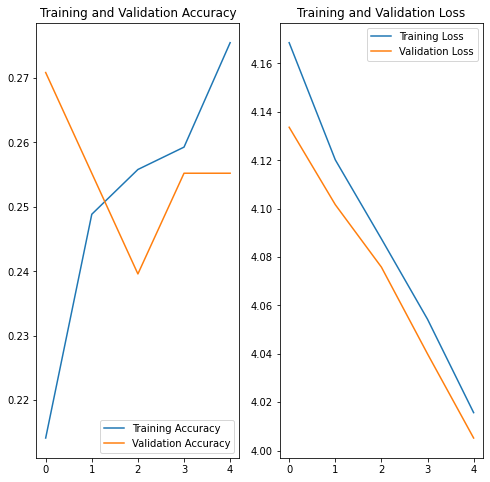

In [52]:
plot_loss(history[0])

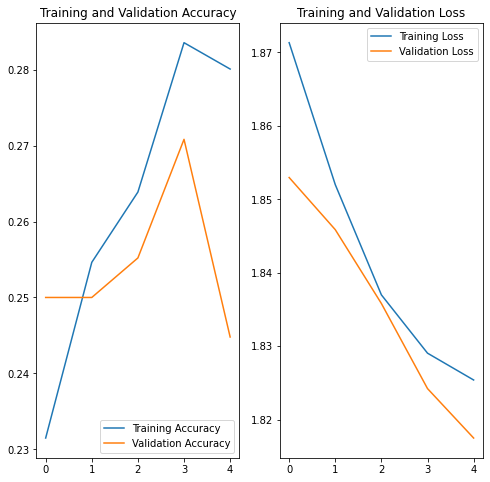

In [53]:
plot_loss(history[1])

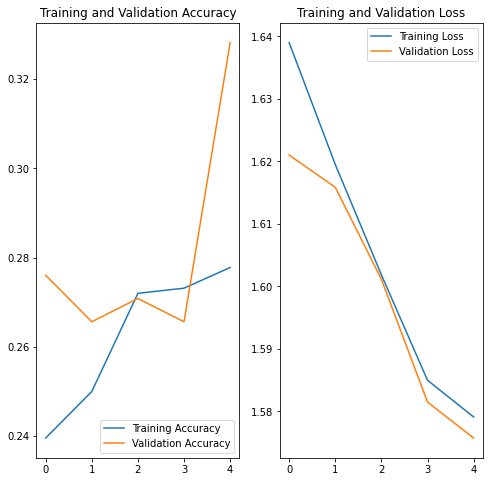

In [54]:
plot_loss(history[2])

# 16. Analysing the unknown images

In [1192]:
lis = list(test_generator.labels.values())

In [1193]:
image_idx = np.where(np.array(y_pred_2)==5)[0]

In [1194]:
len(image_idx//32)

81

In [1195]:
faulty_imgs = []
faulty_labels = []
for idx in image_idx:
    faulty_imgs.append(test_generator[idx//32][0][idx%32])
    faulty_labels.append(img_classes[list(test_generator.labels.values())[idx]])

IndexError: list index out of range

In [ ]:
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(3, 8, sharey=True)
    f.set_figwidth(20)
    f.set_figheight(10)
    print(len(axes))
    for i in range(len(images)):
        ax = axes[i//8][i%8]
        ax.imshow(images[i], cmap)
        ax.set_title(captions[i])

In [ ]:
plot_image(faulty_imgs,faulty_labels)

# 17. Plot histograms

In [1201]:
probs_transposed = np.transpose(np.array(y_pred_prob))

In [1202]:
probs_transposed.shape

(5, 246)

In [1203]:
misclassified_points = np.where(np.array(y_true)!=np.array(y_pred))
rightly_classified = []
misclassified = []
for i in range(len(y_true)):
    if i in misclassified_points[0]:
        misclassified.append(probs_transposed[y_pred[i]][i])
    else:
        rightly_classified.append(probs_transposed[y_true[i]][i])

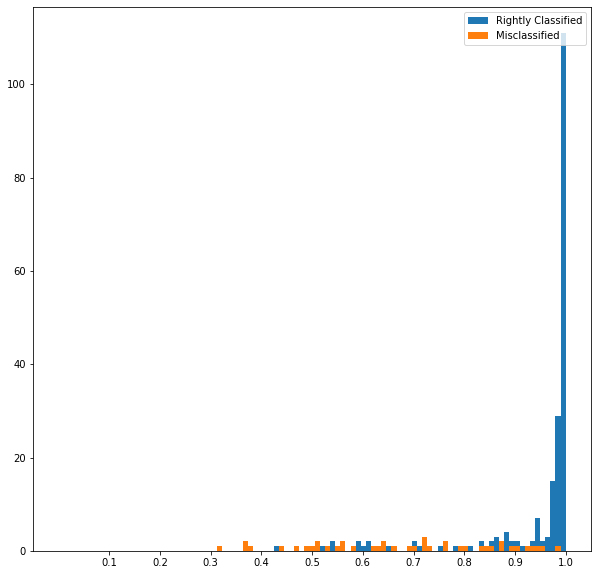

In [1204]:
plt.figure(figsize=(10,10))

plt.hist(rightly_classified,bins = np.linspace(0, 1, 100),label="Rightly Classified")
plt.hist(misclassified,bins = np.linspace(0, 1, 100),label="Misclassified")

plt.legend(loc='upper right')
plt.xticks(np.arange(0.1,1.1,0.1))
plt.show()

# 17. One last attempt

#### Weighted Losses

In [1217]:
ncce = partial(w_categorical_crossentropy, weights=weight)
ncce.__name__ ='w_categorical_crossentropy'

#### Checkpoint

In [1226]:
filepath = 'models/best_model_final.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### LR Decay

In [1222]:
sgd = optimizers.SGD()
decay = DecayLR(base_lr=0.1,decay_rate=0.5,decay_epoch=10)

#### Early Stopping

In [1223]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20,
)

#### Log AUC

In [1227]:
auc_logger = roc_callback()

#### Model

In [1228]:
model = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    


In [1229]:
model.compile(loss=ncce, optimizer=sgd,
              metrics=['accuracy'])

### Run model

In [1232]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

history = model.fit(training_generator, epochs=20, validation_data=validation_generator,callbacks=[auc_logger,decay,checkpoint,early_stopping])

Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 3.0652 - accuracy: 0.2598
Val AUC for epoch0: 0.5057715616016158

Epoch 00001: val_accuracy did not improve from 0.85096
54/54 [==============================] - 60s 1s/step - loss: 3.0652 - accuracy: 0.2598 - val_loss: 1.8525 - val_accuracy: 0.2500 - val_auc: 0.5058
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 1.9009 - accuracy: 0.2465
Val AUC for epoch1: 0.505260765435444

Epoch 00002: val_accuracy did not improve from 0.85096
54/54 [==============================] - 61s 1s/step - loss: 1.9009 - accuracy: 0.2465 - val_loss: 1.8553 - val_accuracy: 0.2500 - val_auc: 0.5053
Epoch 3/20
 9/54 [====>.........................] - ETA: 38s - loss: 1.9290 - accuracy: 0.1910

KeyboardInterrupt: 

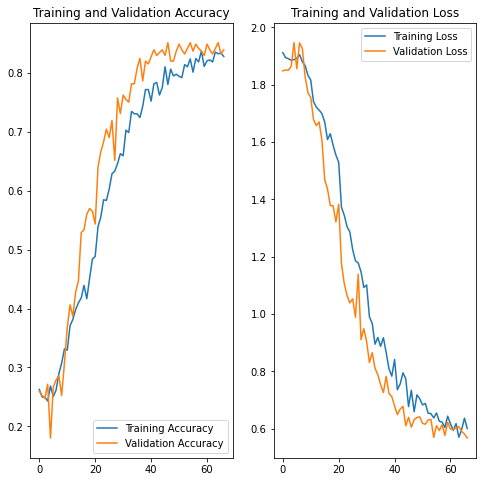

In [1231]:
plot_loss(history)

### Checkpoint

In [1240]:
checkpoint_model_5 = Sequential([
    layers.Conv2D(32, num_channels, padding='valid', activation='relu',input_shape=tuple(list(img_shape)+[num_channels])),
    layers.MaxPooling2D(),
    layers.Conv2D(32, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, num_channels, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])    

In [1241]:
checkpoint_model_5.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=sgd,
              metrics=['accuracy'])

In [1242]:
checkpoint_model_5.load_weights('models/best_model_final.hdf5')

In [1237]:
training_generator = AugmentedDataGenerator('train',train_mode=train_mode, ablation=None)
validation_generator = AugmentedDataGenerator('val',train_mode=train_mode, ablation=None)
test_generator = AugmentedDataGenerator('test',train_mode=train_mode)

In [1239]:
y_true,y_pred,y_pred_prob = get_predictions(checkpoint_model_4,test_generator,thresh=0.45)

In [1180]:
y_true_2,y_pred_2,y_pred_prob_2 = get_predictions(checkpoint_model_2,validation_generator,thresh=0.68)

### Confusion

In [1212]:
confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)

C:\Users\gowdh\AppData\Local\Temp\ipykernel_10424\598330600.py:7: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)


Normalized confusion matrix
Accuracy: 0.821 ||| Normalized Accuracy: 0.878


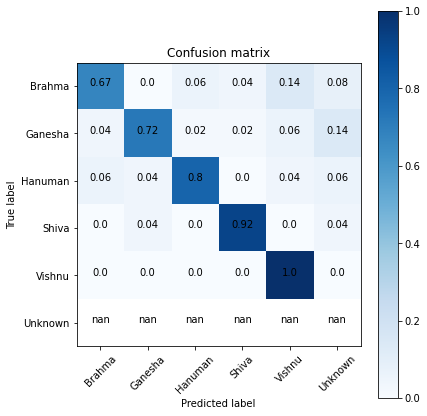

In [1213]:
plot_confusion_matrix(confusion,img_classes+['Unknown'],normalize=True)
accuracy = confusion.trace()/confusion.sum()
normalized_accuracy = confusion[0:5,0:5].trace()/confusion[0:5,0:5].sum()
print("Accuracy: {:.3f} ||| Normalized Accuracy: {:.3f}".format(accuracy,normalized_accuracy))

### ROC curve

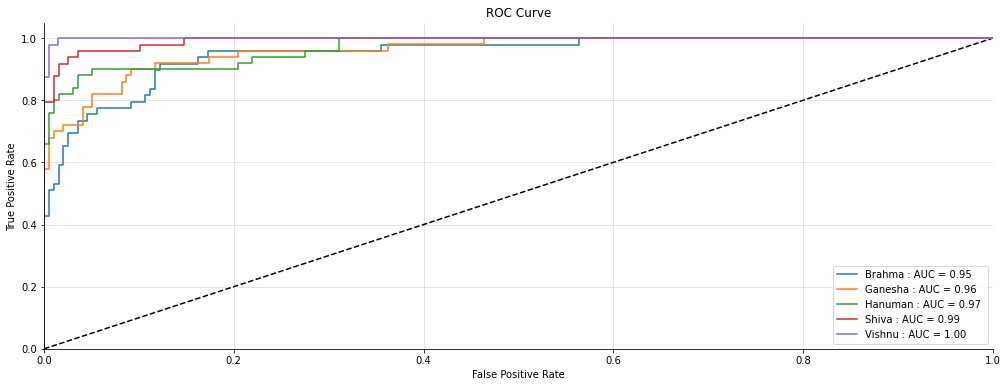

In [963]:
thresh,ix = plot_multiclass_roc(y_pred_prob=y_pred_prob_2,y_test=y_true_2)

In [526]:
confusion.trace()/confusion.sum()

0.8170731707317073

  Brahma    Ganesha    Hanuman    Shiva    Vishnu
--------  ---------  ---------  -------  --------
      24         27          2        4        43
Actual = Hanuman ||| Predicted = Unknown


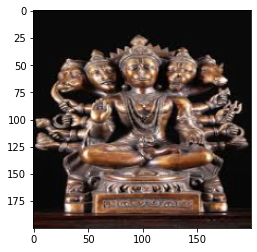

In [1324]:
predict_random(checkpoint_model_2,test_generator)

In [1325]:
img_classes


['Brahma', 'Ganesha', 'Hanuman', 'Shiva', 'Vishnu']

# 18. Gradcam Heatmaps 

In [118]:
import matplotlib.cm as cm
from IPython.display import Image, display


In [78]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    plt.imshow(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256)/256)[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [164]:
final_model = tf.keras.models.load_model('models/model_higher_res.hdf5')
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 199, 199, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 197, 197, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 98, 98, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 64)       

In [181]:
test_generator = AugmentedDataGenerator('val')

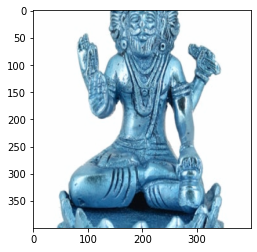

In [195]:
X,y = test_generator[np.random.randint(1,len(test_generator))]
rand = np.random.randint(1,len(X))
img = np.float32(X[rand])
img = np.expand_dims(img,axis=0)


In [178]:
heatmap = make_gradcam_heatmap(img, final_model, 'conv2d_14')

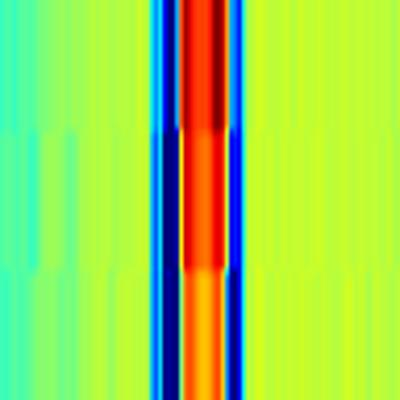

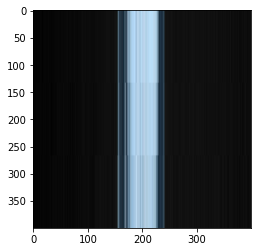

In [179]:
save_and_display_gradcam(np.squeeze(img,axis=0), heatmap)

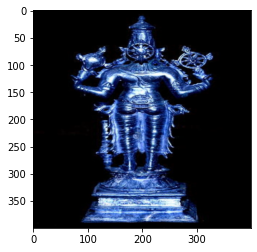

In [215]:
plt.imshow(np.squeeze(img,axis=0))
img_pre = np.squeeze(img,axis=0)

In [216]:
crop_factor = min(img_pre.shape[0:2]) / max(img_pre.shape[0:2])
print("Crop factor",crop_factor)
print(img_pre.shape)
if img_pre.shape[0] > img_pre.shape[1]:
    crop = img_pre[int(img_pre.shape[0] * (1 - crop_factor) / 2):int(img_pre.shape[0] * (1 + crop_factor) / 2), :]
else:
    crop = img_pre[:, int(img_pre.shape[1] * (1 - crop_factor) / 2):int(img_pre.shape[1] * (1 + crop_factor) / 2)]

Crop factor 1.0
(400, 400, 3)


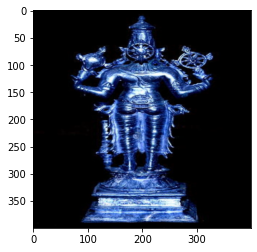

In [217]:
plt.imshow(crop)